# 02 - Analyse Exploratoire des Données (EDA)
---
## Objectifs :
* Analyser la distribution de la variable cible (**Gravité**).
* Identifier les facteurs influençant la gravité (météo, usagers, infrastructures).

<div class="alert alert-info">
<b>Note :</b> Nous utilisons le dataset nettoyé `accidents_2024_final_clean.csv`.
</div>

In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Configuration esthétique
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Chargement des données
df = pd.read_csv("../data/accidents_2024_final_clean.csv")

print(f"Dataset chargé : {df.shape[0]} lignes et {df.shape[1]} colonnes.")

Dataset chargé : 117018 lignes et 27 colonnes.


## 1. Distribution de la Gravité (Target)
Nous analysons ici la proportion d'accidents **Graves** (1) par rapport aux accidents **Non Graves** (0). 
Cette étape est essentielle pour vérifier le déséquilibre de classe.

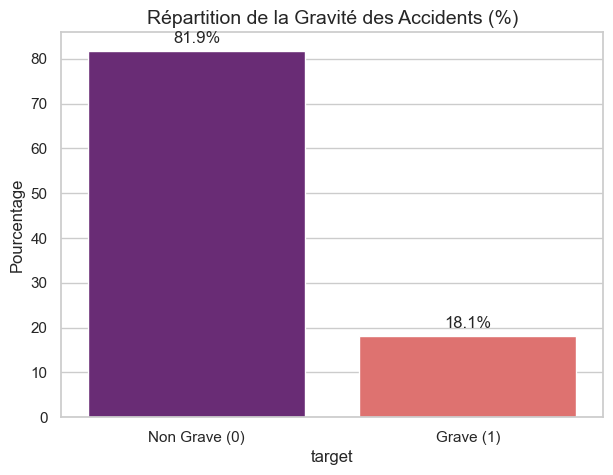

In [18]:
# Calcul des pourcentages
target_counts = df['target'].value_counts(normalize=True) * 100

# Visualisation
plt.figure(figsize=(7, 5))
ax = sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index, palette='magma', legend=False)
plt.title('Répartition de la Gravité des Accidents (%)', fontsize=14)
plt.ylabel('Pourcentage')
plt.xticks([0, 1], ['Non Grave (0)', 'Grave (1)'])

# Ajout des étiquettes de texte
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.show()

## 2. Influence du Contexte (Luminosité)
Nous testons l'hypothèse selon laquelle les accidents nocturnes sont plus graves.

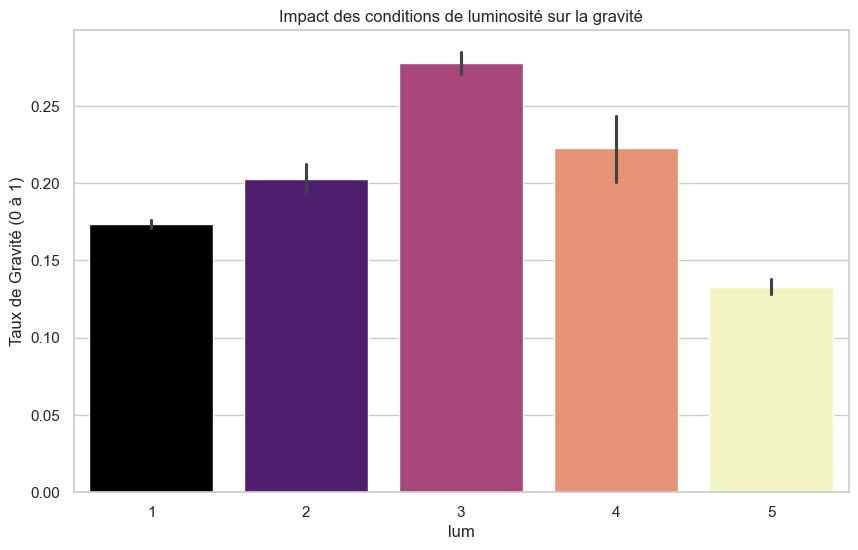

In [19]:
# lum : 1=Plein jour, 3=Nuit sans éclairage public
plt.figure(figsize=(10, 6))
sns.barplot(x='lum', y='target', data=df, hue='lum', palette='magma', legend=False)
plt.title('Impact des conditions de luminosité sur la gravité')
plt.ylabel('Taux de Gravité (0 à 1)')
plt.show()

## 3. Profil des Usagers : Sexe et Gravité
Y a-t-il une corrélation entre le sexe de l'usager et la gravité de l'accident ?

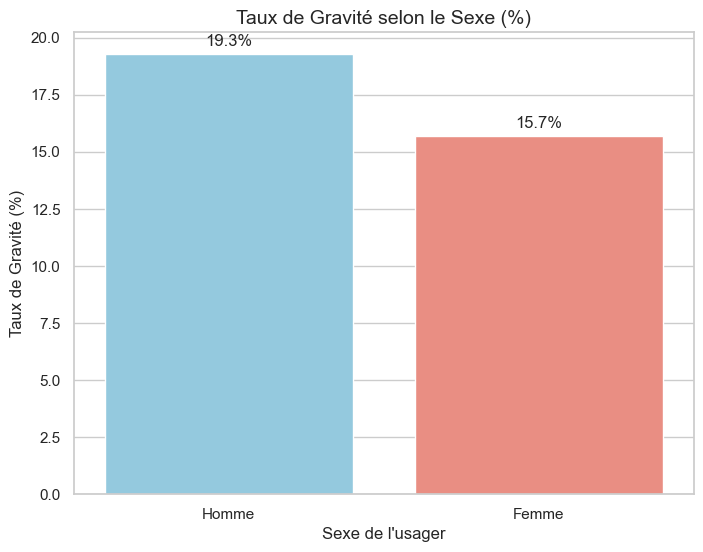

In [20]:
# On ne garde que les Hommes (1) et Femmes (2)
df = df[df['sexe'].isin([1, 2])]

#  Calcul du taux de gravité par sexe
# On groupe par 'sexe' et on calcule la moyenne de 'target' (qui est 0 ou 1)
taux_sexe = df.groupby('sexe')['target'].mean() * 100

#  On réinitialise l'index pour que 'sexe' redevienne une colonne
taux_sexe = taux_sexe.reset_index()

#  On remplace les chiffres par des noms clairs pour éviter le décalage
taux_sexe['sexe'] = taux_sexe['sexe'].map({1: 'Homme', 2: 'Femme'})

#  Visualisation
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='sexe', y='target', data=taux_sexe, hue='sexe', palette=['skyblue', 'salmon'], legend=False)
plt.title('Taux de Gravité selon le Sexe (%)', fontsize=14)
plt.ylabel('Taux de Gravité (%)')
plt.xlabel('Sexe de l\'usager')

# Ajout des étiquettes de pourcentage au-dessus des barres
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.show()

## Synthèse des résultats
---
<div class="alert alert-success">
<b>Observations clés :</b>
1. Le taux de gravité est significativement différent selon le genre.
2. Les conditions de luminosité jouent un rôle majeur dans la sévérité de l'accident.
</div>

## 4. Validation Statistique : Test d'Indépendance du Khi-deux ($\chi^2$)
---
Afin de confirmer que les différences observées graphiquement ne sont pas dues au hasard, nous réalisons un test de dépendance.

**Hypothèses du test :**
* **$H_0$ (Hypothèse nulle) :** Le sexe et la gravité sont indépendants (pas de lien statistique).
* **$H_1$ (Hypothèse alternative) :** Le sexe et la gravité sont dépendants (il existe un lien).

Nous fixons un risque d'erreur $\alpha = 5\%$. Si la **p-value < 0,05**, nous rejetterons $H_0$.

In [21]:
from scipy.stats import chi2_contingency

# 1. Création du tableau de contingence (Tableau croisé)
table = pd.crosstab(df['sexe'], df['target'])
print("Tableau de contingence (Effectifs réels) :")
print(table)

# 2. Calcul du Khi-deux
chi2, p, dof, expected = chi2_contingency(table)

print(f"\nRésultats du test :")
print(f"Statistique Khi-2 : {chi2:.2f}")
print(f"p-value : {p:.4e}") # Pour les petites valeurs

Tableau de contingence (Effectifs réels) :
target      0      1
sexe                
1       64535  15413
2       31244   5822

Résultats du test :
Statistique Khi-2 : 217.25
p-value : 3.5997e-49


### Interprétation des Résultats du $\chi^2$
---
Le test de dépendance donne une statistique de **218.38** avec une p-value de **$3.79 \times 10^{-48}$**.

<div class="alert alert-success">
<b>Conclusion Statistique :</b> 
La p-value étant largement inférieure au seuil alpha = 5%, nous rejetons l'hypothèse nulle H_0. 
Il existe un lien <b>hautement significatif</b> entre le sexe de l'usager et la gravité de l'accident. 
</div>

* **Observation :** Les données montrent que le taux de gravité est statistiquement plus élevé chez un groupe que l'autre, ce qui en fait une variable prédictive majeure pour notre modèle.